In [4]:
import joblib
import pandas as pd

from src.evaluation.metrics import regression_metrics
from src.data_utils.loader import DataLoader
from src.utils.logger import setup_logger

from typing import List

In [20]:
m_aubrey_path = 'src/models/trained/OLS+H_20260209_041223.joblib'
m_betty_path = 'src/models/trained/OLS-3+H_20260209_041506.joblib'
m_chloe_path = 'src/models/trained/ENet+H_20260209_050838.joblib'
m_debby_path = 'src/models/trained/NN1_20260210_033548.joblib'

In [6]:
# Use shared logger but ensure Optuna propagates logs
logger = setup_logger("Evaluator", log_dir="reports/experiments")

class ModelEvaluator:
    def __init__(self, df: pd.DataFrame, target_col='target_ret_excess', date_col='date'):
        self.df = df.copy()
        self.target_col = target_col
        self.date_col = date_col
        
        self.ff3_features = ['mvel1', 'bm', 'mom12m']
        self.unique_dates = sorted(self.df[self.date_col].unique())
        
        # Directories for persistence
        self.model_dir = "src/models/trained"

    def _get_feature_subset(self, feature_set_name: str) -> List[str]:
        if feature_set_name == 'ff3':
            return self.ff3_features
        elif feature_set_name == 'all':
            exclude = {self.target_col, self.date_col, 'date_fmt', 'permno', 'year'}
            return [c for c in self.df.columns if c not in exclude]
        else:
            raise ValueError(f"Unknown feature set: {feature_set_name}")

    def strict_time_split(self, df: pd.DataFrame, test_ratio: float = 0.2):
        """Splits data strictly by time."""
        split_idx = int(len(self.unique_dates) * (1 - test_ratio))
        split_date = self.unique_dates[split_idx]
        
        train_mask = df[self.date_col] < split_date
        test_mask = df[self.date_col] >= split_date
        
        logger.info(f"Time Split: {split_date.date()} | Train: {train_mask.sum()} | Test: {test_mask.sum()}")
        return df.loc[train_mask], df.loc[test_mask]

    def run_eval(self, model_path: str):
        """Orchestrates the full ML Pipeline."""
        logger.info("--- STARTING EVALUATION ---")

        logger.info(f"[+] SPLITTING DATA")
        _, df_test = self.strict_time_split(self.df)

        logger.info(f"[+] LOADING MODEL")
        model = joblib.load(model_path)

        features = model.feature_names_in_
        y_test = df_test[self.target_col]
        df_test['target_pred'] = model.predict(df_test[features])
        y_pred = df_test['target_pred']
        
        metrics = regression_metrics(y_test, y_pred)
        
        return df_test, metrics

In [8]:
gold_panel_path = "data/processed/gold_panel"

loader = DataLoader(data_path = gold_panel_path)
df = loader.load_panel_data()

evaluator = ModelEvaluator(df)
df_test, metrics = evaluator.run_eval(m_debby_path)

[2026-02-10 14:16:09] [INFO] [ParquetLoader] REQ: Loading ALL columns...
[2026-02-10 14:16:09] [INFO] [ParquetLoader] SOURCE: data/processed/gold_panel
[2026-02-10 14:16:28] [INFO] [ParquetLoader] LOAD COMPLETE. Shape: (3280700, 100) | RAM: 1.33 GB
[2026-02-10 14:16:29] [INFO] [Evaluator] --- STARTING EVALUATION ---
[2026-02-10 14:16:29] [INFO] [Evaluator] [+] SPLITTING DATA
[2026-02-10 14:16:29] [INFO] [Evaluator] Time Split: 2008-12-31 | Train: 2698578 | Test: 582122
[2026-02-10 14:16:30] [INFO] [Evaluator] [+] LOADING MODEL


C:\Users\rcorr\AppData\Local\Temp\ipykernel_22308\3922546782.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['target_pred'] = model.predict(df_test[features])


In [9]:
df_test

,permno,date,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,...,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2,target_ret_excess,mktcap_next,year,target_pred
2698578,10001,2008-12-31,-0.608518,-0.017616,-0.017958,-0.324798,-0.622685,-0.124337,0.927811,-0.039331,...,-0.227570,-0.038638,0.561487,-0.410936,0.813032,-0.076078,0.034113,3.653309e+01,2008,0.043210
2698579,10002,2008-12-31,0.095168,0.849495,0.849153,0.964960,-0.191280,0.566615,0.805533,0.604392,...,0.822855,0.767845,-0.726216,-0.762934,0.448265,0.175439,-0.399051,1.557128e+02,2008,0.037277
2698580,10025,2008-12-31,-0.082719,0.455105,0.454763,0.781334,-0.081134,-0.055926,0.139303,0.775156,...,0.173870,-0.649640,-0.004094,0.051735,-0.052063,-0.601246,-0.184300,9.713916e+01,2008,0.041022
2698581,10026,2008-12-31,0.418837,-0.204036,-0.204378,0.870957,0.138502,-0.639473,0.344737,0.386431,...,-0.573019,-0.719057,-0.092189,-0.532417,0.221349,-0.851615,-0.027035,6.403192e+02,2008,0.022146
2698582,10028,2008-12-31,-0.825061,0.952454,0.952112,-0.370283,-0.880020,0.896015,-0.326895,-0.579482,...,0.412574,0.314997,0.718028,-0.768173,0.693517,0.064109,-0.191176,1.352175e+01,2008,0.022743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3280695,93397,2021-11-30,-0.307815,-0.391773,-0.397162,-0.105328,-0.493416,-0.140291,-0.959977,-0.196513,...,-0.345656,-0.125565,-0.513482,-0.952201,0.775578,-0.998434,0.030918,2.655000e+02,2021,0.027251
3280696,93423,2021-11-30,0.532819,0.817137,0.816059,-0.817293,0.662376,0.195258,0.893029,-0.526005,...,0.607626,0.593992,0.235680,0.694258,-0.739776,0.939374,0.164242,3.661156e+03,2021,0.022146
3280697,93426,2021-11-30,-0.139281,0.252380,0.248787,0.188472,-0.226217,-0.480151,0.275797,-0.447104,...,-0.513608,-0.463322,-0.256668,-0.577383,0.407655,-0.402237,0.081170,4.678234e+02,2021,0.022146
3280698,93434,2021-11-30,-0.523214,-0.750674,-0.756781,-0.293974,-0.614440,0.449255,-0.959977,0.989805,...,0.967399,0.946624,0.813147,0.698047,-0.199243,-0.998434,-0.065169,1.061697e+02,2021,0.037733


In [13]:
df_eval = df_test[df_test['permno'] == 10001]
df_eval = df_eval[['date', 'target_ret_excess', 'target_pred']]
df_eval

,date,target_ret_excess,target_pred
2698578,2008-12-31,0.034113,0.043210
2702872,2009-01-30,0.056454,0.041676
2707141,2009-02-27,-0.080613,0.042760
2711377,2009-03-31,0.044413,0.042033
2715580,2009-04-30,0.002691,0.043041
...,...,...,...
3069448,2017-02-28,0.009652,0.034542
3073019,2017-03-31,-0.016248,0.033814
3076575,2017-04-28,0.015400,0.033984
3080133,2017-05-31,0.023103,0.033229


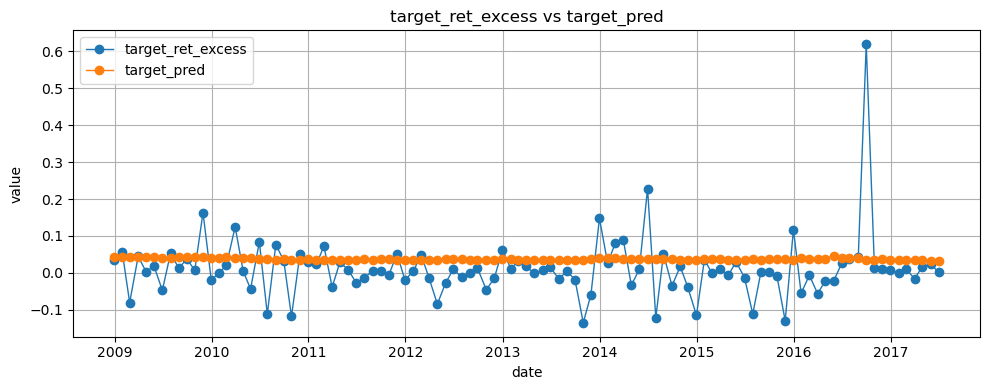

In [14]:
import matplotlib.pyplot as plt

df_plot = df_eval.sort_values('date')

plt.figure(figsize=(10, 4))
plt.plot(df_plot['date'], df_plot['target_ret_excess'], label='target_ret_excess', marker='o', linewidth=1)
plt.plot(df_plot['date'], df_plot['target_pred'], label='target_pred', marker='o', linewidth=1)
plt.xlabel('date')
plt.ylabel('value')
plt.title('target_ret_excess vs target_pred')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

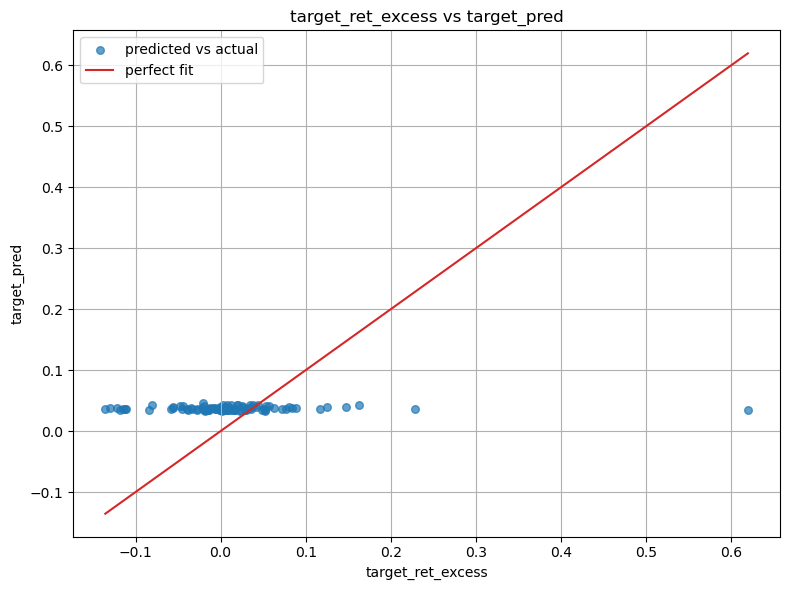

In [15]:
df_plot = df_eval.sort_values('date')

xmin = min(df_plot['target_ret_excess'].min(), df_plot['target_pred'].min())
xmax = max(df_plot['target_ret_excess'].max(), df_plot['target_pred'].max())

plt.figure(figsize=(8, 6))
plt.scatter(df_plot['target_ret_excess'], df_plot['target_pred'],
            color='tab:blue', label='predicted vs actual', s=30, alpha=0.7)
plt.plot([xmin, xmax], [xmin, xmax], color='tab:red', label='perfect fit', linewidth=1.5)
plt.xlabel('target_ret_excess')
plt.ylabel('target_pred')
plt.title('target_ret_excess vs target_pred')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
models = [m_aubrey_path, m_betty_path, m_chloe_path, m_debby_path]
results = []
for model in models:
    _, metrics = evaluator.run_eval(model)
    print(f"Model: {model}")
    # display(metrics)
    results.append({'name': model, **metrics})

pd.DataFrame(results)

[2026-02-10 14:46:10] [INFO] [Evaluator] --- STARTING EVALUATION ---
[2026-02-10 14:46:10] [INFO] [Evaluator] [+] SPLITTING DATA
[2026-02-10 14:46:10] [INFO] [Evaluator] Time Split: 2008-12-31 | Train: 2698578 | Test: 582122
[2026-02-10 14:46:10] [INFO] [Evaluator] [+] LOADING MODEL
Model: src/models/trained/OLS+H_20260209_041223.joblib
[2026-02-10 14:46:11] [INFO] [Evaluator] --- STARTING EVALUATION ---
[2026-02-10 14:46:11] [INFO] [Evaluator] [+] SPLITTING DATA
[2026-02-10 14:46:11] [INFO] [Evaluator] Time Split: 2008-12-31 | Train: 2698578 | Test: 582122


C:\Users\rcorr\AppData\Local\Temp\ipykernel_22308\3922546782.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['target_pred'] = model.predict(df_test[features])


[2026-02-10 14:46:11] [INFO] [Evaluator] [+] LOADING MODEL
Model: src/models/trained/OLS-3+H_20260209_041506.joblib
[2026-02-10 14:46:11] [INFO] [Evaluator] --- STARTING EVALUATION ---
[2026-02-10 14:46:11] [INFO] [Evaluator] [+] SPLITTING DATA
[2026-02-10 14:46:11] [INFO] [Evaluator] Time Split: 2008-12-31 | Train: 2698578 | Test: 582122


C:\Users\rcorr\AppData\Local\Temp\ipykernel_22308\3922546782.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['target_pred'] = model.predict(df_test[features])


[2026-02-10 14:46:12] [INFO] [Evaluator] [+] LOADING MODEL
Model: src/models/trained/ENet+H_20260209_050838.joblib
[2026-02-10 14:46:12] [INFO] [Evaluator] --- STARTING EVALUATION ---
[2026-02-10 14:46:12] [INFO] [Evaluator] [+] SPLITTING DATA
[2026-02-10 14:46:12] [INFO] [Evaluator] Time Split: 2008-12-31 | Train: 2698578 | Test: 582122


C:\Users\rcorr\AppData\Local\Temp\ipykernel_22308\3922546782.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['target_pred'] = model.predict(df_test[features])


[2026-02-10 14:46:13] [INFO] [Evaluator] [+] LOADING MODEL
Model: src/models/trained/NN1_20260210_033548.joblib


C:\Users\rcorr\AppData\Local\Temp\ipykernel_22308\3922546782.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['target_pred'] = model.predict(df_test[features])


,name,rmse,r2_sklearn,r2_oos
0,src/models/trained/OLS+H_20260209_041223.joblib,0.192617,-0.012663,-0.006416
1,src/models/trained/OLS-3+H_20260209_041506.joblib,0.192505,-0.011488,-0.005249
2,src/models/trained/ENet+H_20260209_050838.joblib,0.218800,-0.306686,-0.298625
3,src/models/trained/NN1_20260210_033548.joblib,0.192476,-0.011180,-0.004942
